In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

In [2]:
df = pd.read_csv('homicide_reports.csv', low_memory=False)
print(df.shape)
print(df.columns)
df.head()

(638454, 24)
Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')


,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [3]:
#make the feature headings more python friendly
words = [w.replace(' ', '_') for w in df.columns]
words = [w.lower() for w in words]
df.columns = words

Let's go ahead and jump in and start exploring the data!

In [4]:
df.dtypes

record_id                 int64
agency_code              object
agency_name              object
agency_type              object
city                     object
state                    object
year                      int64
month                    object
incident                  int64
crime_type               object
crime_solved             object
victim_sex               object
victim_age                int64
victim_race              object
victim_ethnicity         object
perpetrator_sex          object
perpetrator_age          object
perpetrator_race         object
perpetrator_ethnicity    object
relationship             object
weapon                   object
victim_count              int64
perpetrator_count         int64
record_source            object
dtype: object

In [5]:
for col in df:
    print('Unique ' + col + ' variables:', df[col].nunique())

Unique record_id variables: 638454
Unique agency_code variables: 12003
Unique agency_name variables: 9216
Unique agency_type variables: 7
Unique city variables: 1782
Unique state variables: 51
Unique year variables: 35
Unique month variables: 12
Unique incident variables: 1000
Unique crime_type variables: 2
Unique crime_solved variables: 2
Unique victim_sex variables: 3
Unique victim_age variables: 101
Unique victim_race variables: 5
Unique victim_ethnicity variables: 3
Unique perpetrator_sex variables: 3
Unique perpetrator_age variables: 101
Unique perpetrator_race variables: 5
Unique perpetrator_ethnicity variables: 3
Unique relationship variables: 28
Unique weapon variables: 16
Unique victim_count variables: 11
Unique perpetrator_count variables: 11
Unique record_source variables: 2


In [6]:
#drop features that are just unqiue codes for law enforcement and are not helpful to analysis
df = df.drop(['record_id', 'agency_code', 'agency_name', 'incident'], 1)

In [7]:
#convert several features category types
for cols in ['agency_type', 'state', 'crime_type', 'victim_sex', 'victim_race', 'victim_ethnicity',
        'perpetrator_sex', 'perpetrator_race', 'perpetrator_ethnicity', 'relationship', 'weapon',
         'record_source']:
    df[cols] = df[cols].astype('category')
    
#convert perpetrator age to integer
df['perpetrator_age'] = df['perpetrator_age'].replace(' ', 0)
df['perpetrator_age'] = df['perpetrator_age'].astype('int64')

#covert month and year to a single datetime format
df['month'] = df['month'].astype(str)
df['year'] = df['year'].astype(str)
df['date'] = df['month'] + ' ' + df['year']
df['date'] = pd.to_datetime(df['date'], format='%B %Y')

#change 'Native America/Alaska Native' to 'Indigenous'
df['perpetrator_race'] = df['perpetrator_race'].replace('Native American/Alaska Native', 'Indigenous')
df['victim_race'] = df['victim_race'].replace('Native American/Alaska Native', 'Indigenous')

In [9]:
#function to quickly group by a feature
def group_features(feature):
    feature_df = pd.DataFrame(df.groupby(feature).size())
    feature_df = feature_df.reset_index()
    feature_df = feature_df.rename(index=str, columns={0: 'murders'})
    return feature_df

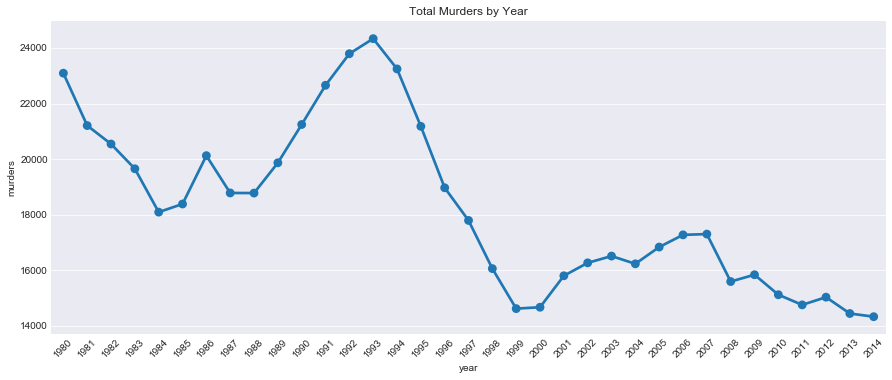

In [10]:
year_df = group_features('year')
year_df = year_df.astype(int)

sns.set_style('darkgrid')
sns.factorplot(x='year', y='murders', data=year_df, size=5, aspect=2.5)
plt.xticks(rotation=45)
plt.title('Total Murders by Year')

plt.show()

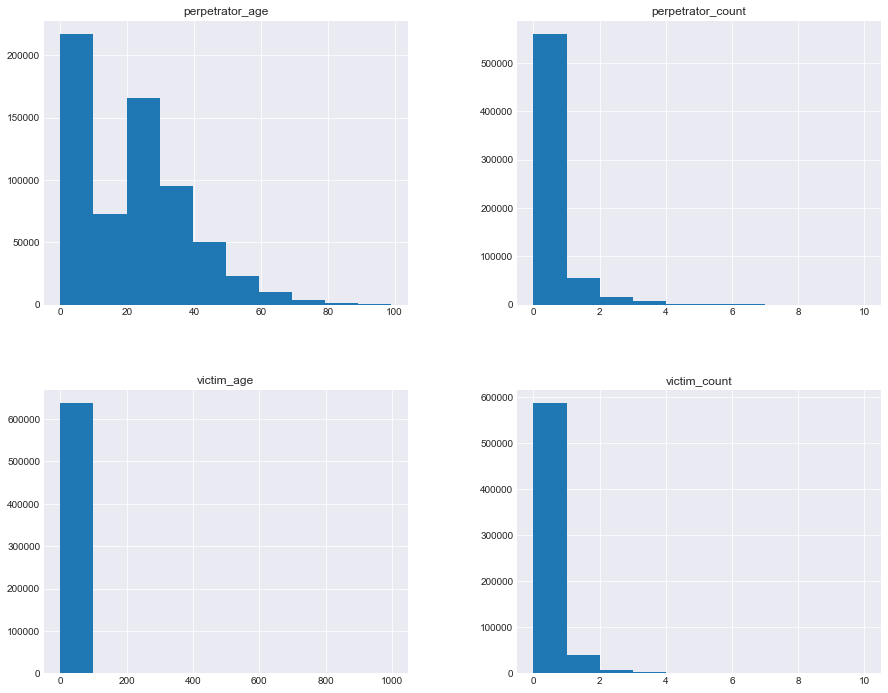

In [11]:
#look at the distribution of all remaining integers types
(df.select_dtypes(include=['int64'])).hist(figsize=(15,12))
plt.show()

In [12]:
#infants aren't 200k infants murdering anyone and there aren't 998 year old people to be murdered
age_df = df
age_df = age_df[age_df['perpetrator_age'] > 0]
age_df = age_df[age_df['victim_age'] < 99]

C:\Users\zberma2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


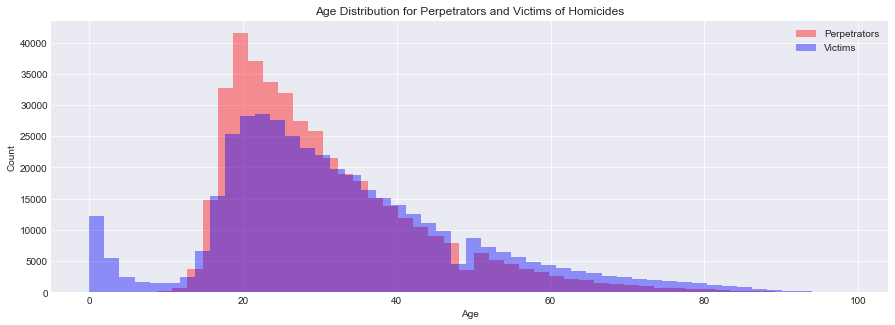

In [13]:
plt.figure(figsize=(15, 5))
sns.distplot(age_df['perpetrator_age'].dropna(), color='red', kde=False, label='Perpetrators')
sns.distplot(age_df['victim_age'].dropna(), color='blue', kde=False, label='Victims')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution for Perpetrators and Victims of Homicides')
plt.legend()

plt.show()

In [21]:
def heatmap_plot(col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2])
    plot = sns.heatmap(crosstab, annot=True, fmt='d', linewidths=.5, cmap='Reds', cbar=False)
    return plot

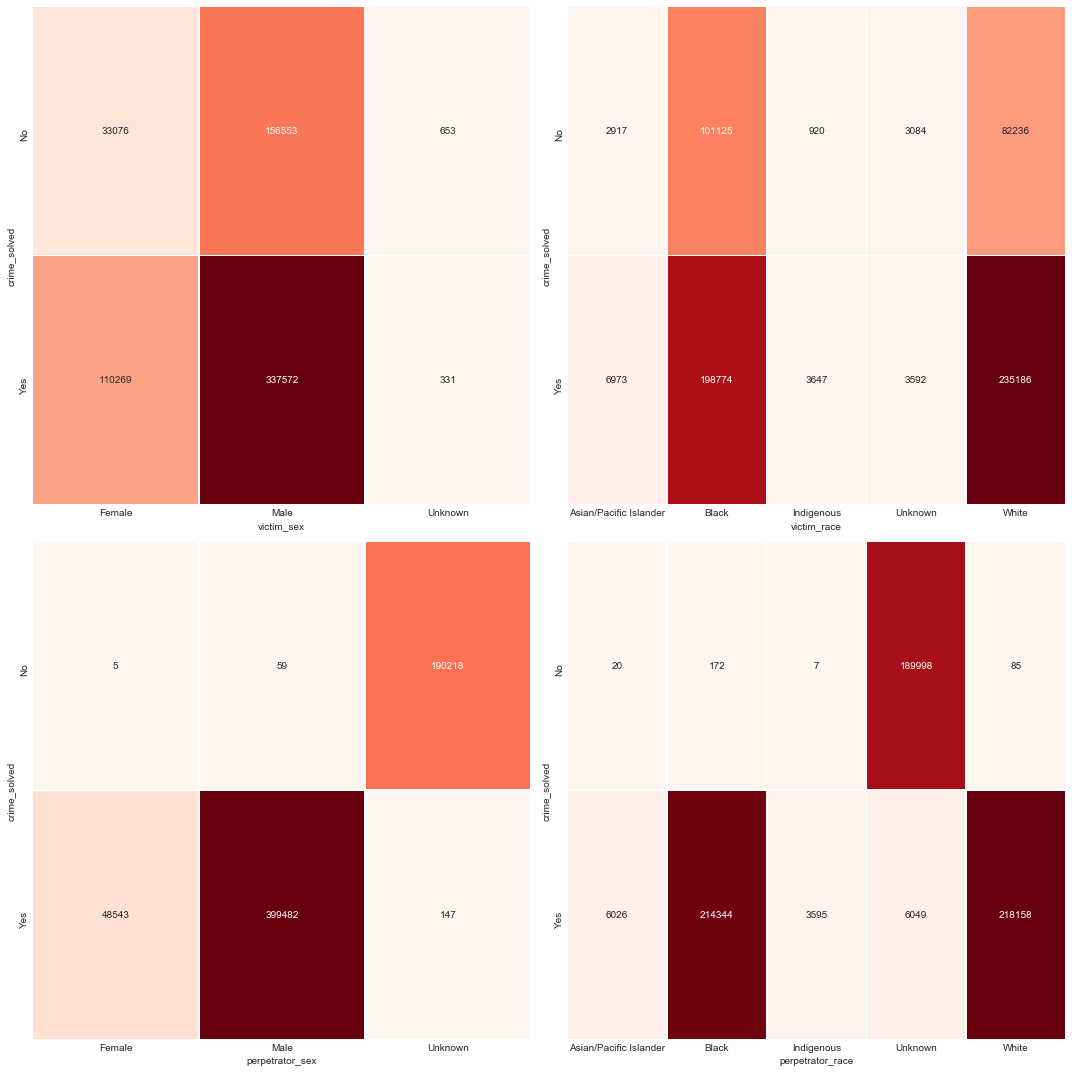

In [24]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
heatmap_plot('crime_solved', 'victim_sex')

plt.subplot(2, 2, 2)
heatmap_plot('crime_solved', 'victim_race')

plt.subplot(2, 2, 3)
heatmap_plot('crime_solved', 'perpetrator_sex')

plt.subplot(2, 2, 4)
heatmap_plot('crime_solved', 'perpetrator_race')

plt.tight_layout()
plt.show()